# Initiation

In [1]:
# To manipulate arrays
import numpy as np 
# To handle track DataFrames
import pandas as pd
# For working with x-arrays
import xarray as xr
# To import images
from skimage import io 
from skimage.io import imread
# For TrackPy
import trackpy as tp
# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter1d
import seaborn as sns; sns.set()  
# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths
# For reloading a library when testing
# For deleting/reloading modules in another file for code testing
import sys
# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../croparray")
import crop_array_tools as ca
os.chdir(cwd)
# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 
plt.style.use('dark_background')


In [2]:
# parameters
particle_diameter= 7 #(3, 7, 7)   # Spot diameter :  z,y,x size of the spot      
tracking_channel = 0          # Channel  used for tracking
min_trajectory_length = 5    # Minimal number of frames to be consider as a trajectory

# selecting time and z for visualization
selected_time = 4 
selected_z = 3 

# Visualization. Static image taking a given time point. Plotting the maximum projection in Z for a given channel.
selected_channel = 0
drop_size = 3

# Video directory
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'  

In [3]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
video.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)

(1, 33, 7, 472, 312, 3)

In [4]:
video2D = np.max(video[0,:,:,:,:,tracking_channel] ,axis=1)
video2D.shape

(33, 472, 312)

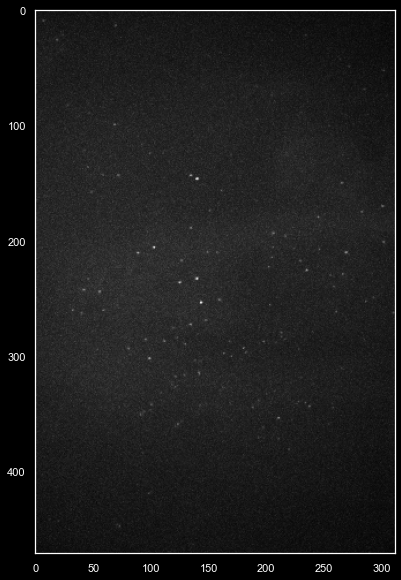

In [5]:
# Just examining one of the images
f = plt.figure(figsize=(10,10))
plt.imshow(video2D[0,:,:],cmap='gray')
plt.grid(False)

# Tracking with trackpy

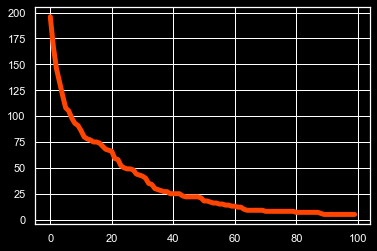

In [6]:
# Detecting particles for each frame
num_spots = []
num_iterations = 100
tested_intensities = np.round(np.linspace(50, np.amax(video2D), num_iterations ),0)
for i, int_tested in enumerate (tested_intensities):
    try:
        f = tp.locate(video2D[0,:,:], diameter=particle_diameter, minmass = int_tested )
        num_spots.append(len(f))
    except:
        num_spots.append(0)
num_spots =np.array(num_spots)        
plt.plot(num_spots, linewidth=5, color='orangered')

In [7]:
print(np.amin(video2D))

print(np.amax(video2D))

7
255


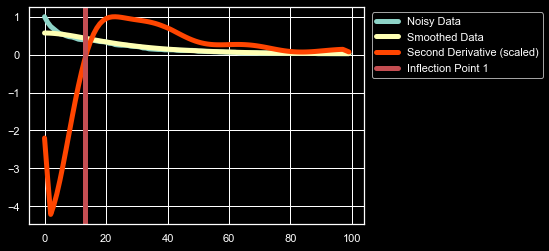

In [8]:
# https://stackoverflow.com/a/62538912/14672920
# Optimization process for selecting intensity
raw = num_spots/ np.max(num_spots)
# smooth
smooth = gaussian_filter1d(raw, 10)
# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))
# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]
# plot results
plt.plot(raw, label='Noisy Data',linewidth=5)
plt.plot(smooth, label='Smoothed Data',linewidth=5)
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)',color='orangered',linewidth=5)
for i, infl in enumerate(infls, 1):
    plt.axvline(x=infl, color='r', label=f'Inflection Point {i}',linewidth=5)
plt.legend(bbox_to_anchor=(1.55, 1.0))

In [9]:
infls

array([13])

In [10]:
selected_minmass = np.round(tested_intensities [infls[0]],0)
selected_minmass

77.0

In [11]:
# Batch process
f = tp.batch(video2D, diameter=particle_diameter,minmass=selected_minmass)

Frame 32: 72 features


In [12]:
# Linking trajectories
linked = tp.link_df(f, 10)
linked

Frame 32: 72 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,9.553957,6.896882,114.610822,1.398012,0.200465,16.215920,1102.0,-1.504064,0,0
55,287.466071,111.612500,153.913814,1.412950,0.172537,21.163149,1665.0,0.199089,0,1
54,286.237895,95.440000,130.551896,1.345558,0.259100,19.514073,1705.0,0.184265,0,2
53,284.767742,122.461290,85.202290,1.501612,0.145049,10.993844,1505.0,0.293559,0,3
52,280.361345,212.857143,98.120056,1.457137,0.015536,14.017151,1418.0,0.395641,0,4
...,...,...,...,...,...,...,...,...,...,...
2420,204.202174,300.250000,97.001484,1.452135,0.163935,12.230622,1318.0,0.617545,32,384
2419,203.403716,237.358108,124.836693,1.444351,0.219367,17.291569,1539.0,0.271222,32,149
2417,185.887202,270.225597,97.212357,1.446066,0.285558,13.074113,1490.0,0.309735,32,150
2434,243.320076,233.253788,111.340834,1.322160,0.142293,17.080696,1363.0,0.490114,32,455


In [13]:
# Filtering with minimum length
filtered_df = tp.filter_stubs(linked, min_trajectory_length)

In [14]:
# Renaming columns names
filtered_df['z']= 0  
filtered_df.rename(columns={'x': 'xc','y': 'yc', 'z': 'zc', 'frame': 'f','particle':'id','mass':'MEAN_INTENSITY'}, inplace=True, errors='raise')
# Chaning data type
spots = filtered_df.astype({'zc': int,'yc': int,'xc': int,'f': int,'id': int,'MEAN_INTENSITY': int})
spots['fov']= 0  
# Selecting some columns
spots=spots[['fov','id','f','zc','yc','xc','MEAN_INTENSITY']]
spots

,fov,id,f,zc,yc,xc,MEAN_INTENSITY
frame,,,,,,,
0,0,0,0,0,9,6,114
0,0,1,0,0,287,111,153
0,0,2,0,0,286,95,130
0,0,5,0,0,276,119,97
0,0,6,0,0,273,134,178
...,...,...,...,...,...,...,...
32,0,133,32,0,204,136,138
32,0,74,32,0,204,98,235
32,0,384,32,0,204,300,97


In [15]:
# From trackpy ids are not in order nor consecutive. This code replaces these values and make them ordered consecutive numbers.
unique_spots_id = spots.id.unique() # unique spots ids
# Replacing spots with id number.
for i,id_spot in enumerate(unique_spots_id):
    spots.loc[spots.id == id_spot,'id']=- i # To avoid replacing and mixing different numbers. I am making the new id a negative number.
spots['id'] = spots['id'].abs() # now getting the absolute value.
print('Detected trajectories: ',np.max(spots.id)+1 )
n_particles = spots['id'].nunique()
spots

Detected trajectories:  129


,fov,id,f,zc,yc,xc,MEAN_INTENSITY
frame,,,,,,,
0,0,0,0,0,9,6,114
0,0,1,0,0,287,111,153
0,0,2,0,0,286,95,130
0,0,3,0,0,276,119,97
0,0,4,0,0,273,134,178
...,...,...,...,...,...,...,...
32,0,63,32,0,204,136,138
32,0,48,32,0,204,98,235
32,0,123,32,0,204,300,97


# Plotting trajectories

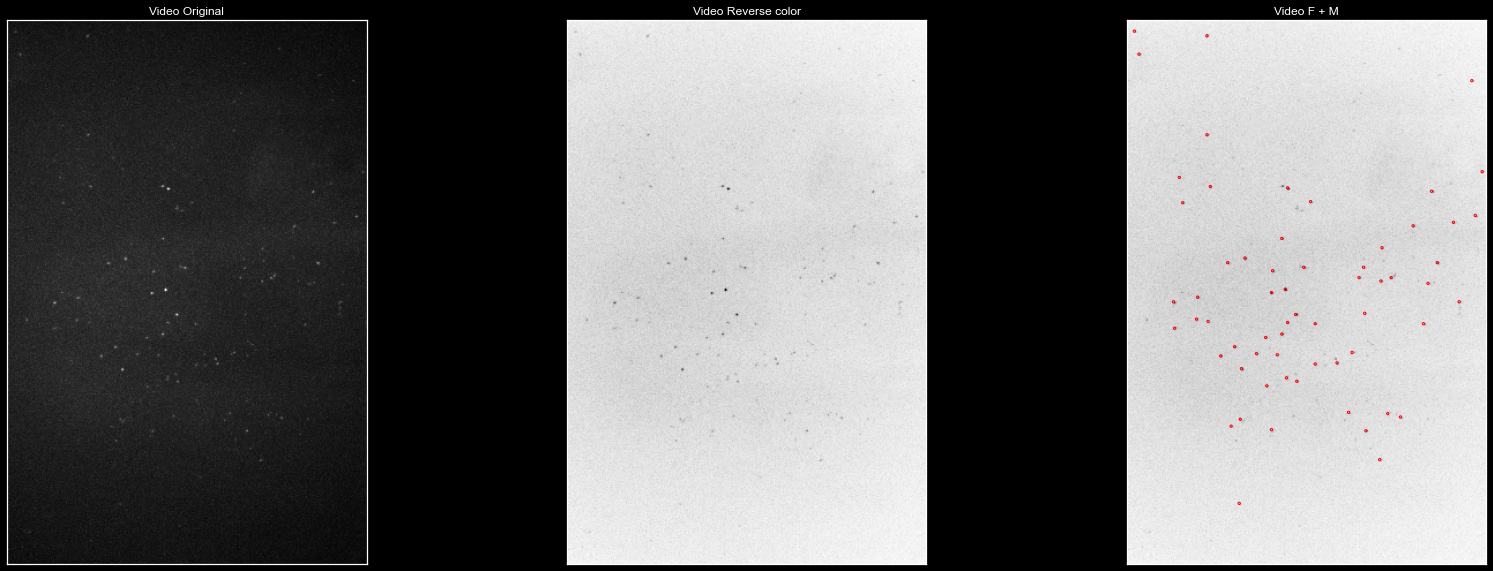

In [16]:
NUM_ROWS = 1
NUM_COLUMNS = 3
index_video = 0
title_str = 'Video'
individual_figure_size = 10
gs = gridspec.GridSpec(NUM_ROWS, NUM_COLUMNS)
gs.update(wspace = 0.01, hspace = 0.1) # set the spacing between axes.
fig = plt.figure(figsize = (individual_figure_size*NUM_COLUMNS, individual_figure_size*NUM_ROWS))

# Figure with raw video
ax = fig.add_subplot(gs[index_video])
img_projection=np.max(video[0,selected_time,:,:,:,selected_channel] ,axis=0)
ax.imshow(img_projection,cmap='gray') 
ax.set_xticks([])
ax.set_yticks([])
ax.set(title = title_str + ' Original')
# Figure with filtered video
ax = fig.add_subplot(gs[index_video+1])
ax.imshow(img_projection,cmap='gray_r') 
ax.set_xticks([])
ax.set_yticks([])
ax.set(title = title_str + ' Reverse color' )
# Figure with filtered video and marking the spots
ax = fig.add_subplot(gs[index_video+2])
ax.imshow(img_projection,cmap='gray_r') 
# Plots the detected spots.
for k in range (0, n_particles):
    frames_part = spots.loc[spots['id'] == spots['id'].unique()[k]].f.values
    if selected_time in frames_part: # plotting the circles for each detected particle at a given time point
        index_val = np.where(frames_part == selected_time)
        x_pos = int(spots.loc[spots['id'] == spots['id'].unique()[k]].xc.values[index_val])
        y_pos = int(spots.loc[spots['id'] == spots['id'].unique()[k]].yc.values[index_val])
        circle = plt.Circle((x_pos, y_pos), drop_size//2, color = 'red', fill = False)
        ax.add_artist(circle)
ax.set_xticks([])
ax.set_yticks([])
ax.set(title = title_str + ' F + M' ) 
plt.show()

# Creatng croparray

In [17]:
my_ca = ca.create_crop_array(video,spots,xy_pad=5)
my_ca

Original video dimensions:  (1, 33, 7, 472, 312, 3)
Padded video dimensions:  (1, 33, 7, 484, 324, 3)
Max # of spots per frame:  65
Shape of numpy array to hold all crop intensity data:  (1, 65, 33, 7, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 65, 33, 3)
Shape of extra my_layers numpy array:  (3, 1, 65, 33)


<xarray.Dataset>
Dimensions:         (fov: 1, n: 65, t: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * fov             (fov) int64 0
  * n               (n) int64 0 1 2 3 4 5 6 7 8 9 ... 56 57 58 59 60 61 62 63 64
  * t               (t) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * z               (z) int64 0 1 2 3 4 5 6
  * y               (y) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x               (x) int64 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch              (ch) int64 0 1 2
Data variables:
    int             (fov, n, t, z, y, x, ch) int64 11 13 12 16 17 ... 0 0 0 0 0
    xc              (fov, n, t, ch) int64 12 12 12 186 186 186 ... 0 0 0 0 0 0
    yc              (fov, n, t, ch) int64 15 15 15 299 299 299 ... 0 0 0 0 0 0
    dx              int64 1
    dy              int64 1
    dz              int64 1
    dt              int64 1
    id              (fov, n, t) float64 0.0 14.0 13.0 2.0 ... 0.0 0.0 0.0 0.0
    zc              (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    MEAN_INTENSITY  (fov, n, t) float64 114.0 161.0 146.0 138.0 ... 0.0 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

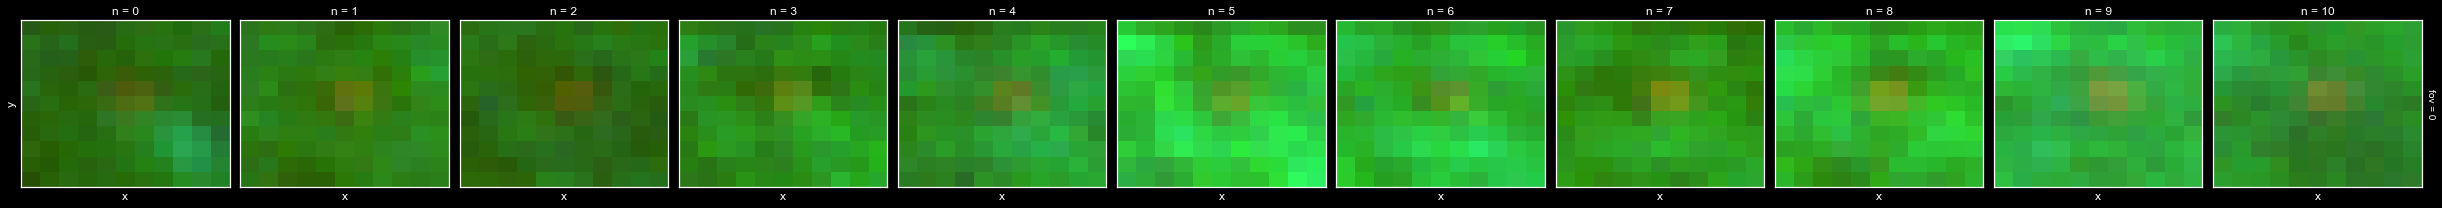

In [18]:
# Check the first 10 spots (max-z projected) of each fov to make sure things are centered. 
# Choosing ch = 1, 2 (translation), and 3 for rgb mapping
my_ca.int.sel(ch=[0,1,2],n=slice(0,10)).mean(dim=['t']).max('z').plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[])

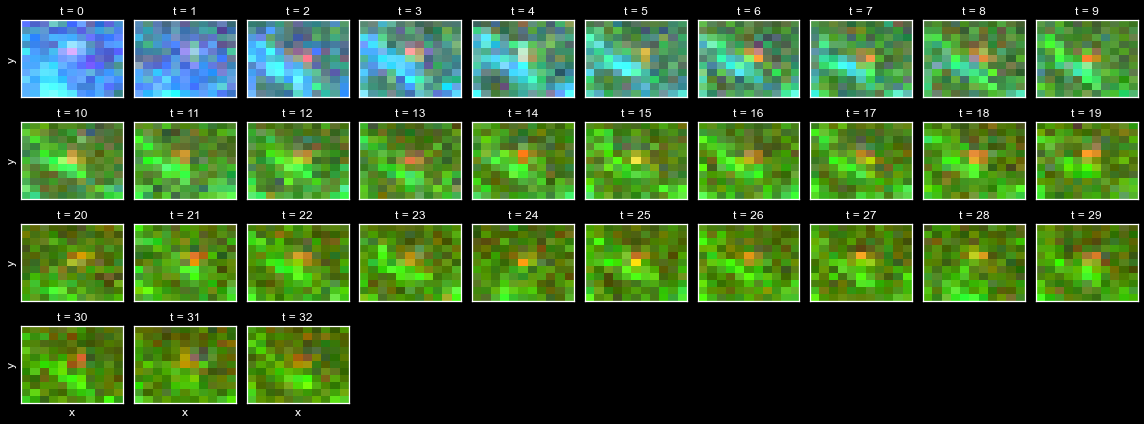

In [19]:
# Plot one of the crops over time to test
best_z = ca.best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
best_z.where(my_ca.id==20).mean('n').sel(fov=0).plot.imshow(col='t',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5)

# Sorting crop ids by average translation signal intensity through time

---

In [20]:
# Create best-z projection (if not already)
#best_z = best_z_proj(my_ca, ref_ch=0, disk_r=2, roll_n=3)

# Make a background subtracted x-array for plotting on same scale
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
best_z_bg = best_z -donut_sig

# Now sort based on signal average over time with disk-donut intensity
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
signal = disk_sig - donut_sig
my_ca['signal'] = signal
my_ca['signal'].attrs['notes']='Disk donut on best_z_bg w/ ref_ch=0, disk_r=4, roll_n=3, donut_r = 5-6'

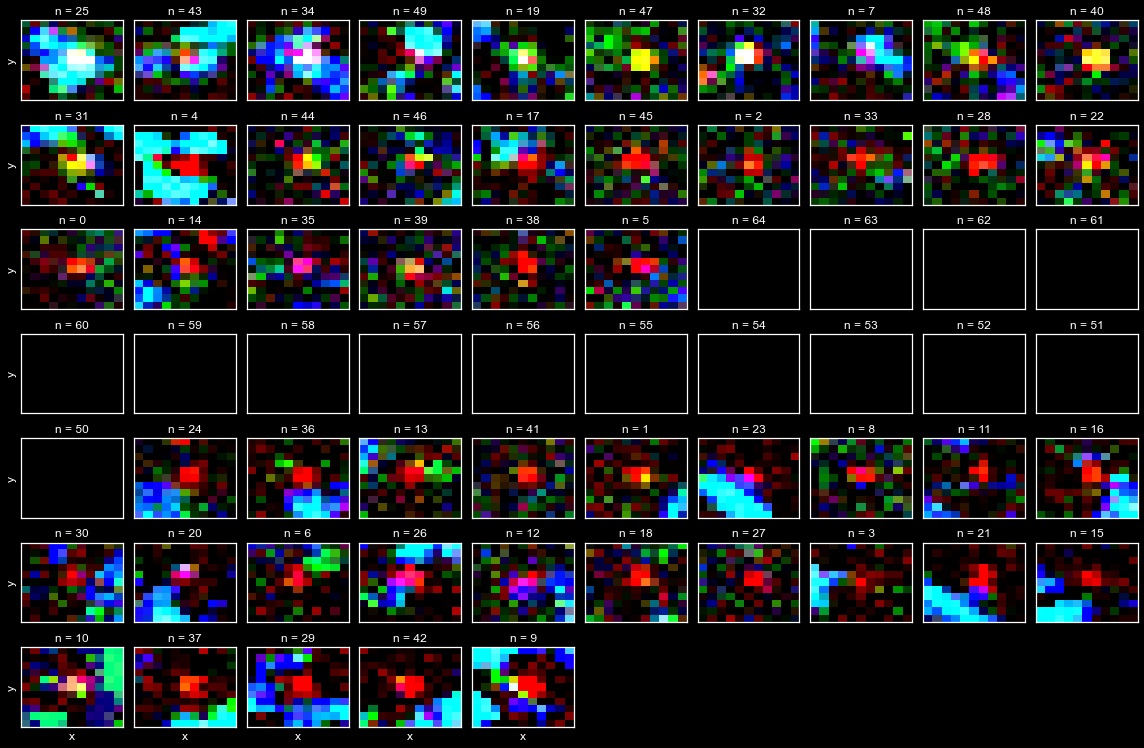

In [21]:
# Visualize the sorted spots t = 0
ca_sort = best_z_bg.sel(t=0).sortby(my_ca.signal.sel(t=0,ch=1,fov=0),ascending=False)
ca_sort.sel(fov=0).plot.imshow(col='n',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,vmin=0,vmax=30)

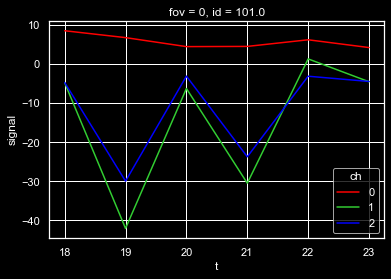

In [22]:
# If ids correspond to tracks, we can also visualize tracks through time  
my_id = np.unique(my_ca.id) # Find all unique ids

# We create a dataset with 'id' as a coordinate in this case
track_sig = xr.concat([my_ca.signal.where(my_ca.id == i).mean(['n']) for i in my_id],dim=pd.Index(my_id, name='id')).to_dataset()

# This allows us to focus on specific tracks in plots:
sns.set_palette(['red','limegreen','blue'])
track_sig.sel(id=101,fov=0).signal.plot.line(x='t',hue='ch')

In [23]:
# Now we sort the trck ids by the mean intensity of each track through time 
# We can look for tracks with bright translation signals, but dim mature protein signals 
# For this, we sort by translation signal - mature protein signal (or could do any variant)
sorted = track_sig.sortby(track_sig.signal.sel(fov=0,ch=1).mean('t'),ascending=False)
sorted_ids = sorted.id.values.astype(int)
sorted_ids

array([  3, 122, 100,  85, 120,  49,  43,   5,  58,  54,  44,  34,  40,
        91,  42,  20,  66,  57,   1,  31,  17,   6,  47,  74,  13,  60,
        50, 118, 128,  87,  53,  32, 115,  56,  39,  81,  36,  52,  93,
        26,  22,  79,  48,  68,  88,   7, 103,  61,  10, 116,   8,  33,
        67,  84, 109,  72, 102, 121,  45, 127,  35,  83, 107,  82,   0,
        70,  78, 111,  30,  11,  96, 119, 105,  92,  76,  46, 112,  38,
        25,  51,  16,  28,  62,  18,  75,  65,  89,  27,  71,  21, 114,
        95,  80,  12,  98,  24, 124, 123,  55,   2,  19,  63,  59,  77,
       125,  99,  23,  29,  90,  86,  73,  94, 106,  15,   4,  41,   9,
        69,  64, 110,  97, 104,  14, 117, 108, 101, 113,  37, 126])

In [24]:
# To visualize the time-averaged tracks all sorted, we create a crop array and plot it 
sorted_xr = xr.concat([best_z_bg.where(my_ca.id==i, drop=True).mean(dim=['n']) for i in sorted_ids], dim=pd.Index(sorted_ids, name='id'))

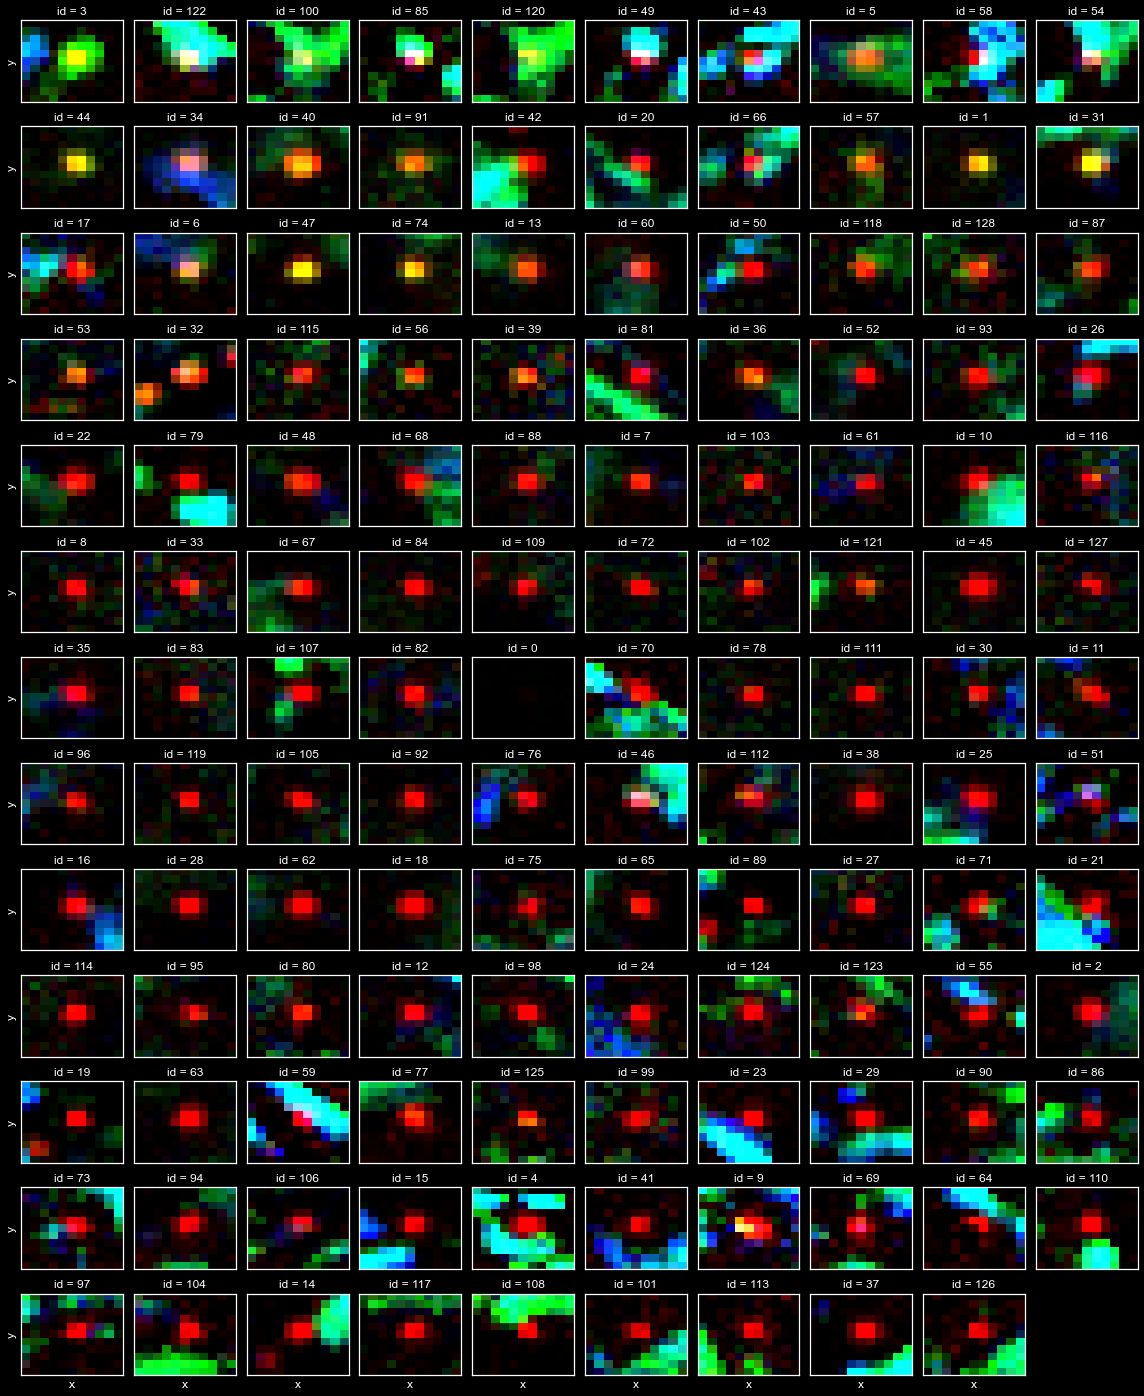

In [25]:
sorted_xr.sel(fov=0).mean('t').plot.imshow(col='id',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5, vmin=0, vmax=30)

In [26]:
crop_array = ca.montage(my_ca, row = 't', col = 'n').int.sel(ch=0)

In [27]:
crop_array.shape

(1, 7, 363, 715)

# Plotting a croparray

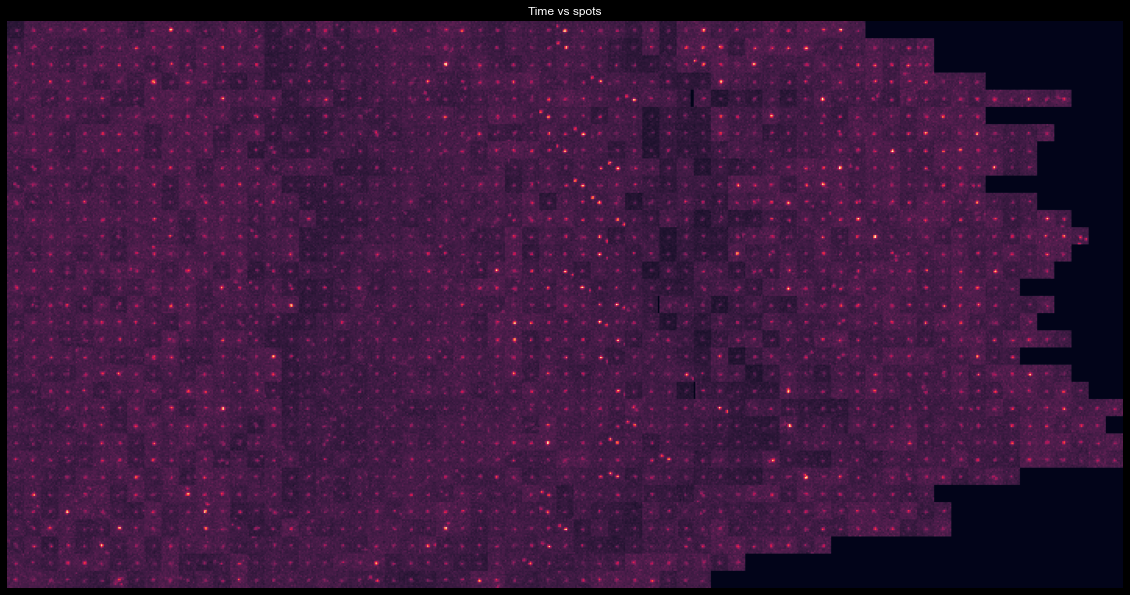

In [28]:
# Plotting
f = plt.figure(figsize=(20,15))
ax = plt.gca()
plt.imshow(np.max(crop_array[0,:,:,:],axis=0))
plt.title("Time vs spots")
plt.grid(False)
plt.axis('off')
plt.show()